# City transit optimization

In general, it refers to the process of improving the efficiency of a city's public transportation systems, such as buses, trains, and subways. This can involve a variety of strategies, such as implementing advanced routing algorithms, implementing real-time tracking systems, and incorporating new technologies like electric vehicles and autonomous vehicles. The goal of city transit optimization is to reduce congestion, decrease travel times, and increase overall satisfaction with the transit system.

# What this project is about
This playground project is an attempt to optimize bus locations of a simplified city's public transportation system.

In addition, it is also a demonstration that the PyTorch library can be used for optimizing parameters that don't necessarily represent Neural Networks. In this project, the bus locations will be the optimizable parameters.

## Data representation
The project will work with extremely simplified data, represented in a graph.
1. Nodes

  The nodes will consist only of random sources and destinations. These are 2D coordinates in a square area of size 1. Next, bus stations are defined as 2D coordinates as well. The bus station locations are initialized to be uniformly distributed. The area will not contain any roads, buildings, or other types of information commonly found on maps. 


2. Edges

  Initially, bus stations that are on the same longitude will form a bus line. Similar bus lines will be created for latitude.
Sources and destinations will be connected to bus stations in their proximity. Sources and destinations will also be directly connected.
To make the project more familiar, the edge weights will represent the time to move from one point to another.

## What metric will be optimized
The project will attempt to optimize the total amount of time to reach all destinations from their corresponding sources.


## Generating artificial data
This is a useful approach for modeling and testing the performance of a city transit optimization project, as it allows for the creation of simplified scenarios that can be more easily understood and analyzed. Artificial data eliminates the complexity and variability of actual data and allows one to focus on the specific elements that are being evaluated.

Our artificial dataset will consist of pairs of sources and destination coordinates.

The source coordinates are represented in orange, the destinations are represented in blue, and there is a green line connecting sources to destinations.

sources, destinations shapes:  (80, 2) (80, 2)


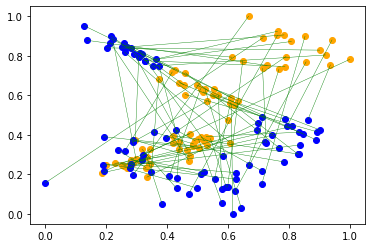

In [15]:
import transit_util
import importlib
importlib.reload(transit_util)
import importlib
import matplotlib.pyplot as plt
import numpy as np

sources, destinations = transit_util.get_data()

print("sources, destinations shapes: ", sources.shape, destinations.shape)

plt.scatter(sources[:, 0], sources[:, 1], color='orange')
plt.scatter(destinations[:, 0], destinations[:, 1], color='blue')

for i in range(sources.shape[0]):
    plt.plot([sources[i, 0], destinations[i, 0]],[sources[i, 1], destinations[i, 1]], color='green',  linewidth=0.4)
    
plt.show()

Assuming that the amount of time to reach a destination from a source is simply the euclidian distance between them, let's see what is the total amount of time simply by walking. This will be the baseline metric value that the project will try to improve. 

In [16]:
total_distance = np.linalg.norm((sources - destinations), axis=1).sum()
print(f"Total time to walk between sources and destinations: {total_distance:.2f}")

Total time to walk between sources and destinations: 33.55


In the figure below, the bus stations will be defined. Their locations will be uniformely distributed. 

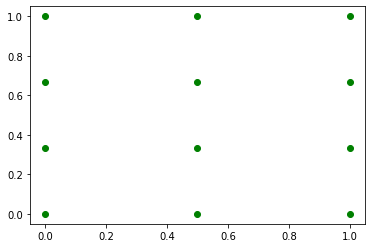

In [17]:
import transit_util
importlib.reload(transit_util)

bus_stations, nodes, line_finding_x, line_finding_y, DX, DY = transit_util.get_dummy_busstations(sources, destinations)
plt.scatter(bus_stations[:, 0], bus_stations[:, 1], color='green')
plt.show()

At this point, the graph will begin its definition. The initial edges will represent bus lines. As it was mentioned at the beginning, bus stations that are on the same longitude will form a bus line and similarly for latitude. Because of that, each bus station will connect 2 bus lines.

Bus lines will have a number associated, starting from 1, and will be represented with different colors.

The edge weights of these bus lines represent the amount of time to move between them. Since the goal is to model buses that are faster than normal walking, their value will be the euclidian distance divided by a constant. In other words, it means buses are X times faster than normal walking. It is important to mention that edge weights will be computed at optimization time during the Djikstra algorithm. That is because with every optimization step, the coordinates of bus stations will change, and the weights will be recomputed.

In the figure below it can be seen the bus lines.

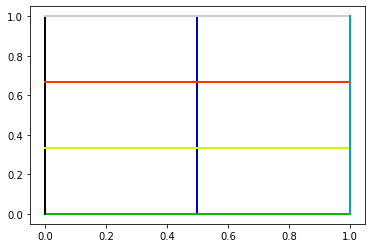

In [18]:
g = transit_util.connect_bus_stations(nodes, line_finding_x, line_finding_y)
cmap = transit_util.get_cmap(len(line_finding_x) + len(line_finding_y))
plt.figure()
for i, node in nodes:
    x, y = node
    for j, _, line in g[i]:
        node = nodes[j][1]
        nx, ny = node
        plt.plot([x, nx],[y, ny], linewidth=2, c=cmap(line))

plt.show()

The next edges that will be added to the graph will be between sources and bus locations in proximity, and destinations and bus locations in proximity. The edge connecting a source/destination to bus stations will have as its weight the euclidian distance. As mentioned earlier, the edge weights are computed at optimization time during the Dijkstra algorithm.

In summary, the goal is to model the fact that it will take time for a person to walk to the bus station, it will take less time to travel using the bus, and it will take some time again to descend and reach its destination.

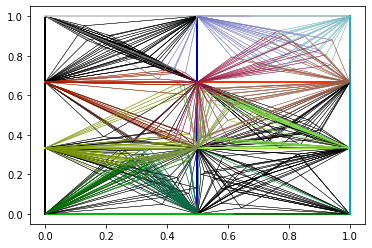

In [19]:
sources_offset, dest_offset, g = transit_util.add_source_and_destination_to_graph(g, sources, destinations, nodes, DX, DY, line_finding_x, line_finding_y)
import random
plt.figure()
for i, node in nodes:
    x, y = node
    for j, d, line in g[i]:
        node = nodes[j][1]
        nx, ny = node
        c=cmap(line)

        d = 0.4
        if i < sources_offset and j < sources_offset:
            d = 2

        plt.plot([x, nx],[y, ny],  linewidth=d, c=c)


Now it is the time to optimize. In the figures below, it can be seen how with every step, the bus locations are changed, and the metric starts to improve.

tensor(36.6372, grad_fn=<AddBackward0>)


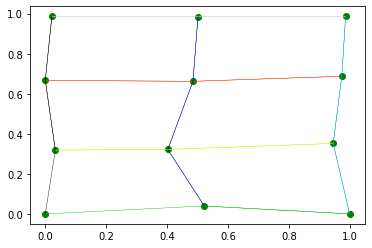

tensor(33.3909, grad_fn=<AddBackward0>)


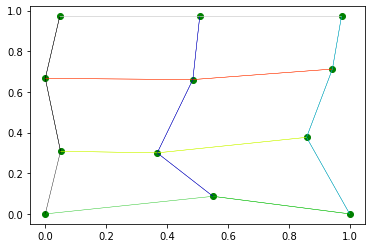

tensor(30.4604, grad_fn=<AddBackward0>)


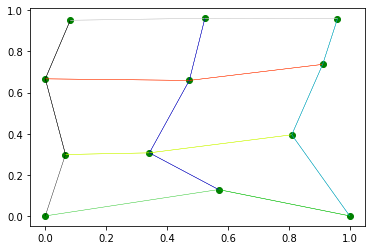

In [20]:
import transit_util
importlib.reload(transit_util)
tg = transit_util.TorchGraph(nodes, sources_offset, dest_offset, g, sources, destinations, cmap)
tg.optimize()

In the figures below it can be seen some of the paths needed to be taken by a passenger starting from its source until reaching its destination.

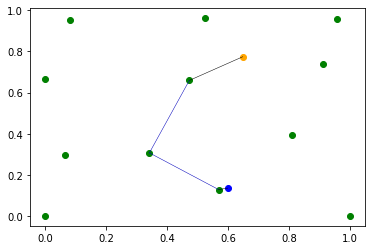

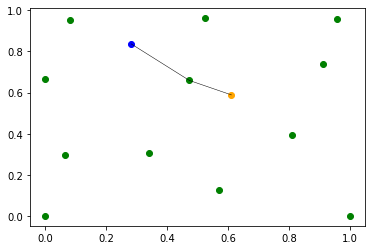

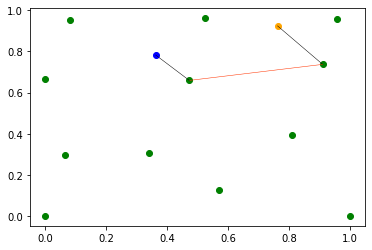

In [21]:
tg.animate_track()

In the figure below it can be seen the bus line usage. Some edges have been removed where no passenger took the bus to demonstrate the fact that such an optimization technique can help find redundant paths that can be removed for improving efficiency.

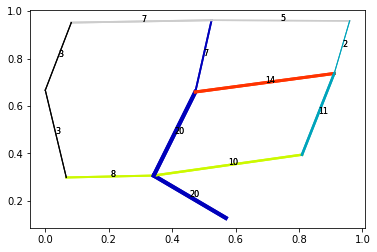

In [22]:
tg.plot_bus_line_usage()

# Potential real world implementation

There are few datasets online that provide the necessary data such as sources and destinations. One such dataset is for [Chicago](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew)

To import the map of Chicago, a tool such as Python [osmnx](https://osmnx.readthedocs.io/en/stable/) can be used.

To import the available bus lines and bus stations, the data could be scraped from https://www.transitchicago.com. [Here](https://www.transitchicago.com/assets/1/6/stoplist_6.htm) is an example of loading a bus line and [here](https://www.transitchicago.com/assets/1/6/stoplist_6.htm) can be found the bus station latitude and longitude.

A good starting project that combines the map and bus station information in osmnx is https://github.com/filipwodnicki/2021sp-final-project-filipwodnicki .

# Conclusion

This playground project serves as an example of how city transit optimization can be approached by using simplified data representation and optimization techniques. The project aims to improve the efficiency of a simplified city's public transportation system by optimizing bus locations. 

The data used in the project is represented in a graph, with nodes consisting of random sources and destinations and edges representing the time to move between them. The project utilizes a simple Djikstra algorithm implemented with PyTorch to provid automatic optimization. 

Through the process of generating artificial data, the project was able to create simplified scenarios that can be easily understood and analyzed. 

The final result of the project showed the effectiveness of the optimization technique in improving the overall efficiency of the transit system and demonstrates the potential for real-world implementation.